# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 5

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [56]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [57]:
# Train–Validation Split

n_samples = X_full.shape[0]
n_train = int(0.7 * n_samples)

# Shuffle indices
indices = torch.randperm(n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:]

# Split the data
X_train, y_train = X_full[train_idx], y_full[train_idx]
X_val, y_val = X_full[val_idx], y_full[val_idx]

print(f"Training Set: {X_train.shape}, {y_train.shape}")
print(f"Validation Set: {X_val.shape}, {y_val.shape}")

Training Set: torch.Size([2100, 2]), torch.Size([2100, 1])
Validation Set: torch.Size([900, 2]), torch.Size([900, 1])


In [58]:
def add_radius_feature(X):
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2).view(-1, 1)
    return torch.cat([X, radius], dim=1)
X_train = add_radius_feature(X_train)
X_val = add_radius_feature(X_val)

print("Updated input shape:", X_train.shape)

Updated input shape: torch.Size([2100, 3])


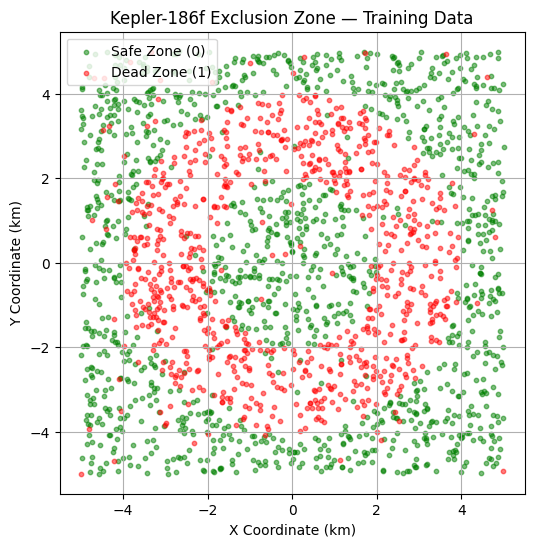

In [59]:
# Visualizing the Sensor Data

plt.figure(figsize=(6, 6))

# Plot Safe Zone (label 0)
plt.scatter(
    X_train[y_train.squeeze() == 0][:, 0],
    X_train[y_train.squeeze() == 0][:, 1],
    c='green',
    s=10,
    label='Safe Zone (0)',
    alpha=0.5
)

# Plot Dead Zone (label 1)
plt.scatter(
    X_train[y_train.squeeze() == 1][:, 0],
    X_train[y_train.squeeze() == 1][:, 1],
    c='red',
    s=10,
    label='Dead Zone (1)',
    alpha=0.5
)

plt.xlabel("X Coordinate (km)")
plt.ylabel("Y Coordinate (km)")
plt.title("Kepler-186f Exclusion Zone — Training Data")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

In [60]:

# Parameter Initialization
learning_rate = 0.1

# Layer 1
# Xavier initialization for tanh: std = sqrt(1 / fan_in)
W1 = torch.randn(3, 16) * np.sqrt(1/3) # fan_in = 3
W1.requires_grad_()
b1 = torch.zeros(1, 16, requires_grad=True)

# Layer 2
W2 = torch.randn(16, 16) * np.sqrt(1/16) # fan_in = 16
W2.requires_grad_()
b2 = torch.zeros(1, 16, requires_grad=True)

# Layer 3
W3 = torch.randn(16, 16) * np.sqrt(1/16) # fan_in = 16
W3.requires_grad_()
b3 = torch.zeros(1, 16, requires_grad=True)

# Output Layer
W4 = torch.randn(16, 1) * np.sqrt(1/16) # fan_in = 16
W4.requires_grad_()
b4 = torch.zeros(1, 1, requires_grad=True)


In [61]:

# Activation Functions & Forward Pass

def tanh(x):
    return torch.tanh(x)
def relu(x):
    return torch.clamp(x, min=0.0)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


def forward_pass(X):

    z1 = torch.matmul(X, W1) + b1
    a1 = tanh(z1)

    z2 = torch.matmul(a1, W2) + b2
    a2 = tanh(z2)

    z3 = torch.matmul(a2, W3) + b3
    a3 = tanh(z3)

    z4 = torch.matmul(a3, W4) + b4
    y_hat = sigmoid(z4)

    return y_hat

In [62]:
def binary_cross_entropy(y_hat, y):

    # Numerical stability: avoid log(0)
    eps = 1e-7
    y_hat_clamped = torch.clamp(y_hat, eps, 1 - eps)

    # BCE loss formula
    loss = -torch.mean(
        y * torch.log(y_hat_clamped) +
        (1 - y) * torch.log(1 - y_hat_clamped)
    )

    return loss

In [65]:
# Now the Training Loop

epochs = 2001

# Storage for HUD plots
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    # TRAINING

    y_hat_train = forward_pass(X_train)
    train_loss = binary_cross_entropy(y_hat_train, y_train)

    # Backpropagation
    train_loss.backward()

    # Manual SGD update
    with torch.no_grad():
        for param in [W1, b1, W2, b2, W3, b3, W4, b4]:
            param -= learning_rate * param.grad
            param.grad.zero_()

    # Training accuracy
    train_preds = (y_hat_train >= 0.5).float()
    train_acc = (train_preds == y_train).float().mean()

    # VALIDATOIN
    with torch.no_grad():
        y_hat_val = forward_pass(X_val)
        val_loss = binary_cross_entropy(y_hat_val, y_val)

        val_preds = (y_hat_val >= 0.5).float()
        val_acc = (val_preds == y_val).float().mean()

    # Store metrics
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    # Progress print (optional but useful)
    if epoch % 50 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss.item():.4f}, "
            f"Val Loss: {val_loss.item():.4f}, "
            f"Train Acc: {train_acc.item():.4f}, "
            f"Val Acc: {val_acc.item():.4f}"
        )

Epoch 000 | Train Loss: 0.6401, Val Loss: 0.6352, Train Acc: 0.6181, Val Acc: 0.6000
Epoch 050 | Train Loss: 0.6349, Val Loss: 0.6298, Train Acc: 0.6195, Val Acc: 0.6067
Epoch 100 | Train Loss: 0.6293, Val Loss: 0.6244, Train Acc: 0.6143, Val Acc: 0.6156
Epoch 150 | Train Loss: 0.6231, Val Loss: 0.6186, Train Acc: 0.6281, Val Acc: 0.6256
Epoch 200 | Train Loss: 0.6156, Val Loss: 0.6118, Train Acc: 0.6286, Val Acc: 0.6278
Epoch 250 | Train Loss: 0.6065, Val Loss: 0.6034, Train Acc: 0.6362, Val Acc: 0.6356
Epoch 300 | Train Loss: 0.5950, Val Loss: 0.5925, Train Acc: 0.6614, Val Acc: 0.6600
Epoch 350 | Train Loss: 0.5803, Val Loss: 0.5783, Train Acc: 0.6833, Val Acc: 0.6767
Epoch 400 | Train Loss: 0.6271, Val Loss: 0.6364, Train Acc: 0.6438, Val Acc: 0.6200
Epoch 450 | Train Loss: 0.5880, Val Loss: 0.5921, Train Acc: 0.6876, Val Acc: 0.6311
Epoch 500 | Train Loss: 0.5791, Val Loss: 0.5838, Train Acc: 0.6919, Val Acc: 0.6333
Epoch 550 | Train Loss: 0.5685, Val Loss: 0.5740, Train Acc: 0.69

/tmp/ipython-input-181373254.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


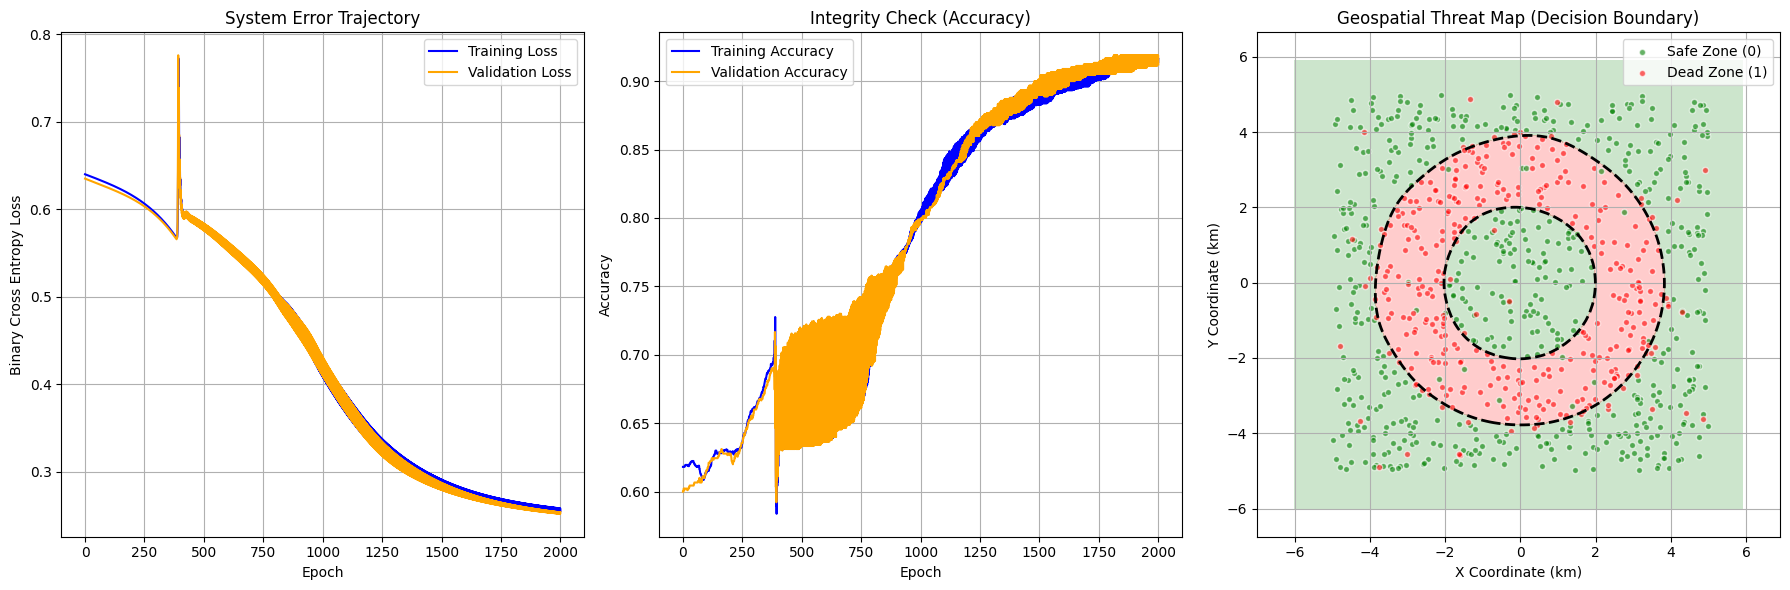

In [66]:
plt.figure(figsize=(18, 6))

# Plot 1 -- System Error Trajectory (Loss Plot)
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('System Error Trajectory')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross Entropy Loss')
plt.legend()
plt.grid(True)

# Plot 2 -- Integrity Check (Accuracy Plot)
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Integrity Check (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 3 -- Geospatial Threat Map (Decision Boundary)
plt.subplot(1, 3, 3)
x_min, x_max = X_full[:, 0].min() - 1, X_full[:, 0].max() + 1
y_min, y_max = X_full[:, 1].min() - 1, X_full[:, 1].max() + 1
h = 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
mesh_points_with_radius = add_radius_feature(mesh_points)

with torch.no_grad():
    Z = forward_pass(mesh_points_with_radius).reshape(xx.shape).numpy()

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['green', 'red'], alpha=0.2)
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)

plt.scatter(
    X_val[y_val.squeeze() == 0][:, 0].numpy(),
    X_val[y_val.squeeze() == 0][:, 1].numpy(),
    c='green', s=20, label='Safe Zone (0)', alpha=0.6, edgecolors='w'
)
plt.scatter(
    X_val[y_val.squeeze() == 1][:, 0].numpy(),
    X_val[y_val.squeeze() == 1][:, 1].numpy(),
    c='red', s=20, label='Dead Zone (1)', alpha=0.6, edgecolors='w'
)

plt.title('Geospatial Threat Map (Decision Boundary)')
plt.xlabel('X Coordinate (km)')
plt.ylabel('Y Coordinate (km)')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True)

plt.tight_layout()
plt.show()